In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# used to supress display of warnings
import warnings

from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

#Download the DS

This code uses the urllib.request module to download a ZIP file from the URL "http://www.anefian.com/research/gt_db.zip" and save it to the local file system with the filename "gt_db.zip". After the file has been successfully downloaded, the code outputs the message "Dataset Downloaded Successfully!".

In [ ]:
import urllib.request

url = "http://www.anefian.com/research/gt_db.zip"
filename = "gt_db.zip"

urllib.request.urlretrieve(url, filename)

print("Dataset Downloaded Successfully!")


Dataset Downloaded Successfully!


Then we extract the files

In [ ]:
import zipfile

filename = "gt_db.zip"

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

print("Dataset Extracted Successfully!")


Dataset Extracted Successfully!


In [ ]:
import urllib.request

url = "http://www.anefian.com/research/labels_gt.zip"
filename = "labels_gt.zip"

urllib.request.urlretrieve(url, filename)

print("Dataset Downloaded Successfully!")


Dataset Downloaded Successfully!


In [ ]:
import zipfile

filename = "labels_gt.zip"

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

print("Dataset Extracted Successfully!")


Dataset Extracted Successfully!


This code is downloading a dataset from Kaggle using the Kaggle API.

The first line pip install -q kaggle installs the Kaggle API package.

The next two lines mkdir ~/.kaggle and cp kaggle.json ~/.kaggle/ create a new directory at ~/.kaggle and copy the kaggle.json file, which contains the API credentials, to that directory.

The chmod 600 ~/.kaggle/kaggle.json line sets the permissions on the API credentials file so that only the user can read and write to it.

Finally, the kaggle datasets download -d vincentscheltjens/vgg-face-weights.h5 line uses the Kaggle API to download the dataset with the ID "vincentscheltjens/vgg-face-weights.h5" and save it to the current working directory.

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d vincentscheltjens/vgg-face-weightsh5

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 515M/521M [00:02<00:00, 188MB/s]
100% 521M/521M [00:02<00:00, 182MB/s]


In [ ]:
!unzip /content/vgg-face-weightsh5.zip

Archive:  /content/vgg-face-weightsh5.zip
  inflating: vgg_face_weights.h5     


#Build the model

The part defines two classes and a function:

IdentityMetadata: This class is used to represent metadata of an identity (e.g. person), which consists of three instance variables: base which represents the base path of the identity, name which represents the name of the identity, and file which represents the name of the image file associated with the identity. This class provides two methods:
__repr__: This method returns the path of the image file associated with the identity.

image_path: This method returns the full path of the image file, which is obtained by joining the base path, the name and the file using the os.path.join function.

load_metadata: This function is used to load metadata from a directory of identities. It takes the path as an argument, which is the path to the directory containing identities. For each sub-directory within the path, it checks if it contains any .jpg or .jpeg files. If it does, it creates an instance of IdentityMetadata with the given path, the sub-directory name and the file name, and appends it to a list of metadata. Finally, the function returns a numpy array of metadata.

In the code, a source_dir variable is defined and set to /content/gt_db, and metadata is loaded using the load_metadata function with source_dir as its argument.

In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')

source_dir = '/content/gt_db'
metadata = load_metadata(source_dir)

In [ ]:
print('metadata shape :', metadata.shape)
print("\n", metadata[749])
print("\n", type(metadata[749]), metadata[749].image_path())

metadata shape : (750,)

 /content/gt_db/s42/08.jpg

 <class '__main__.IdentityMetadata'> /content/gt_db/s42/08.jpg


The code defines a function load_image that takes the path of an image as an argument and returns the image data in the form of a numpy array.

The function uses the OpenCV library's cv2.imread function to read the image file specified by the path argument. This function returns a numpy array that represents the image data.

However, OpenCV loads images with color channels in BGR order, while most other libraries (e.g. Matplotlib) expect RGB order. Therefore, the function returns the reversed order of color channels by slicing the numpy array img and returning only the first three channels in reverse order (img[...,::-1]).

In [ ]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

load_image("/content/gt_db/s02/01.jpg")

array([[[144, 145, 139],
        [145, 146, 141],
        [143, 144, 139],
        ...,
        [125, 119, 131],
        [126, 120, 132],
        [130, 122, 135]],

       [[145, 146, 140],
        [146, 147, 142],
        [144, 145, 140],
        ...,
        [125, 119, 131],
        [125, 119, 131],
        [130, 122, 135]],

       [[144, 145, 139],
        [145, 146, 141],
        [144, 145, 140],
        ...,
        [125, 119, 131],
        [124, 118, 130],
        [129, 121, 134]],

       ...,

       [[ 45,  52,  36],
        [  5,  11,   0],
        [ 16,  19,   8],
        ...,
        [ 20,  15,  21],
        [ 21,  16,  22],
        [ 23,  18,  24]],

       [[ 41,  48,  32],
        [  2,   8,   0],
        [ 13,  16,   5],
        ...,
        [ 18,  13,  19],
        [ 18,  13,  19],
        [ 20,  15,  21]],

       [[ 40,  47,  31],
        [  2,   8,   0],
        [ 13,  16,   5],
        ...,
        [ 20,  15,  21],
        [ 20,  15,  21],
        [ 18,  13,  19]]

<a id = '4.1'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.1 VGG Face model </strong></p>
- Here we are having the predefined model for VGG face

In [ ]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

<p style = "font-size:20px; color: #007580 "><strong> Load the model </strong></p>

- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [ ]:
model = vgg_face()

model.load_weights('vgg_face_weights.h5')

<p style = "font-size:20px; color: #007580 "><strong> Get vgg_face_descriptor </strong></p>

In [ ]:
model.layers[0], model.layers[-2]

(<keras.layers.reshaping.zero_padding2d.ZeroPadding2D at 0x7f2f28dab490>,
 <keras.layers.reshaping.flatten.Flatten at 0x7f2ec9b65190>)

In [ ]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
type(vgg_face_descriptor)

keras.engine.functional.Functional

In [ ]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>])

<a id = '4.2'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.2 Generate embeddings for each image in the dataset </strong></p>

-load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 1s/step
(2622,)


In [ ]:
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(0.022673694, numpy.ndarray, numpy.float32)

In [ ]:
embedding_vector[2], embedding_vector[98], embedding_vector[-2]

(0.025984278, -0.008411018, -0.00027096132)

<p style = "font-size:20px; color: #007580 "><strong> Generate embeddings for all images </strong></p>

-iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

In [ ]:
total_images = len(metadata)

print('total_images :', total_images)

total_images : 750


This code is generating face embeddings using a pre-trained VGG Face model (vgg_face_descriptor).

The embeddings array is initialized with zeros and has a shape of (metadata.shape[0], 2622), where metadata.shape[0] is the number of rows in the metadata, and 2622 is the size of the embedding vectors generated by the VGG Face model.

The code then loops through the metadata and for each instance:

Extracts the path to the corresponding image from the metadata using the image_path() method.
Loads the image using the load_image function.
Normalizes the pixel values of the image by dividing by 255 and converting to a floating-point format.
Resizes the image to (224,224) using OpenCV's cv2.resize function.
Runs the pre-trained VGG Face model on the resized image and generates an embedding vector using vgg_face_descriptor.predict.
Assigns the generated embedding vector to the corresponding row in the embeddings array.

In [ ]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

1/1 [==============================] - 1s 1s/step


In [ ]:
print('embeddings shape :', embeddings.shape)

embeddings shape : (750, 2622)


In [ ]:
embeddings[0], embeddings[740], embeddings[740].shape

(array([ 0.02267369,  0.01406892,  0.02598428, ..., -0.01654591,
        -0.00027096,  0.01691714]),
 array([ 0.00661259,  0.00072916,  0.014205  , ..., -0.00163348,
         0.01082617,  0.01236629]),
 (2622,))

In [ ]:
embeddings[550]

array([ 0.00210347, -0.00074104,  0.01387421, ...,  0.00055829,
        0.00993873,  0.00447382])

<p style = "font-size:20px; color: #007580 "><strong> Function to calculate distance between given 2 pairs of images </strong></p>

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

<a id = '4.3'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.3 Plot images and get distance between the pairs </strong></p>

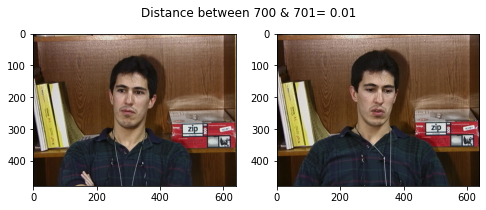

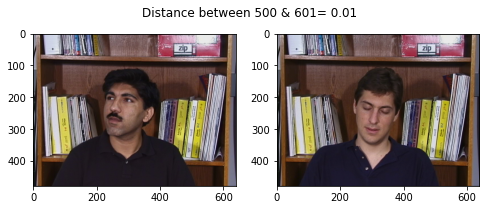

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(700, 701)
show_pair(500, 601)

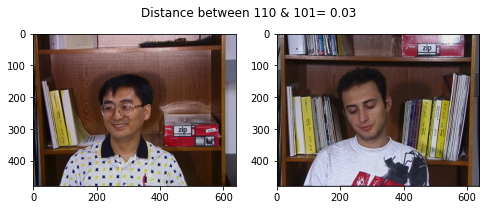

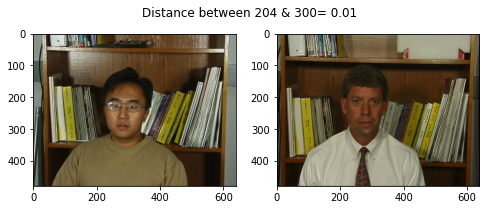

In [ ]:
show_pair(110, 101)
show_pair(204, 300)

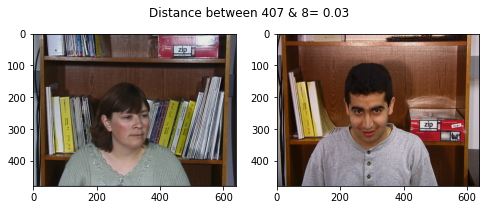

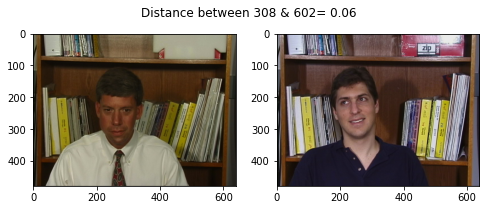

In [ ]:
show_pair(407, 8)
show_pair(308, 602)

<a id = '4.4'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.4 Create train and test sets </strong></p>
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

In [ ]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (666,2622)
y_train shape : (666,)
X_test shape : (84,2622)
y_test shape : (84,)


In [ ]:
y_test[0], y_train[650]

('s29', 's06')

In [ ]:
len(np.unique(y_test)), len(np.unique(y_train))

(50, 50)

<p style = "font-size:20px; color: #007580 "><strong> Encode the Labels </strong></p>
- Encode the targets
- Use LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [ ]:
print(le.classes_)
y_test_encoded = le.transform(y_test)

['s01' 's02' 's03' 's04' 's05' 's06' 's07' 's08' 's09' 's10' 's11' 's12'
 's13' 's14' 's15' 's16' 's17' 's18' 's19' 's20' 's21' 's22' 's23' 's24'
 's25' 's26' 's27' 's28' 's29' 's30' 's31' 's32' 's33' 's34' 's35' 's36'
 's37' 's38' 's39' 's40' 's41' 's42' 's43' 's44' 's45' 's46' 's47' 's48'
 's49' 's50']


In [ ]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [28 28 28 28 28 28 28 28 28 28 28 28 28  4  4  4  4  4  4  4  4  4  4  4
  4  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0 40 40 40 40 40 40 40 40
 40 40 40 40 40 19 19 19 19 19 19 19 19 19 19 19 19 19 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 32 32 32 32 32 32 32 32 32 32 32 32 32 38 38 38
 38 38 38 38 38 38 38 38 38 38 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 48 48 48 48 48 48 48 48 48 48 48 48 48 11 11 11 11 11 11 11 11 11 11 11
 11 11 47 47 47 47 47 47 47 47 47 47 47 47 47 47 18 18 18 18 18 18 18 18
 18 18 18 18 18 46 46 46 46 46 46 46 46 46 46 46 46 46 49 49 49 49 49 49
 49 49 49 49 49 49 49 49 16 16 16 16 16 16 16 16 16 16 16 16 16 24 24 24
 24 24 24 24 24 24 24 24 24 24 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 37 37 37 37 37 37 37 37 37 37 37 37 37  7  7  7  7  7  7  7  7  7  7  7
  7  7 14 14 14 14 14 14 14 14 14 14 14 14 14 14 17 17 17 17 17 17 17 17
 17 17 17 17 17  6  6  6  6  6  6  6  6  6  6  6  6  6 26 26 26 26 26 26
 26 26 26 26 26 26 26 26 13 13 1

<p style = "font-size:20px; color: #007580 "><strong> Standardize the feature values </strong></p> 
- Scale the features using StandardScaler

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [ ]:
X_test_std = scaler.transform(X_test)

<a id = '4.5'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.5 Reduce dimensions using PCA </strong></p> 
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [ ]:
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (666,2622)
y_train_encoded shape : (666,)
X_test_std shape : (84,2622)
y_test_encoded shape : (84,)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

<a id = '5.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 5. Model Building and Validation </h2> 

<a id = '5.1'></a>
<p style = "font-size:20px; color: #007580 "><strong> 5.1 Build a Machine Learning Classifier </strong></p> 

- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [ ]:
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001)

In [ ]:
y_predict = clf.predict(X_test_pca)

In [ ]:
print('y_predict : ',y_predict)
print('y_test_encoded : ',y_test_encoded)

y_predict :  [39 28  4  4  0 40 40 19 19 10 32 32 38 38 43 48 48 11 11 47 18 18 46 46
 49 16 16 24 24 20 37 37  7 39 14 17 17  6  6 26 39 13 23 23 21 25 25  4
 36 31 12 12  8  8 15 30 30 42 42 39 29 29  2  2  3 33 33 34 34  9 35 35
  1  1 27 45 45 22 22 44  5  5 41 41]
y_test_encoded :  [28 28  4  4  0 40 40 19 19 10 32 32 38 38 43 48 48 11 11 47 18 18 46 46
 49 16 16 24 24 20 37 37  7  7 14 17 17  6  6 26 13 13 23 23 21 25 25 36
 36 31 12 12  8  8 15 30 30 42 42 39 29 29  2  2  3 33 33 34 34  9 35 35
  1  1 27 45 45 22 22 44  5  5 41 41]


In [ ]:
y_predict_encoded = le.inverse_transform(y_predict)

In [ ]:
print('y_predict_encoded : ',y_predict_encoded)

y_predict_encoded :  ['s40' 's29' 's05' 's05' 's01' 's41' 's41' 's20' 's20' 's11' 's33' 's33'
 's39' 's39' 's44' 's49' 's49' 's12' 's12' 's48' 's19' 's19' 's47' 's47'
 's50' 's17' 's17' 's25' 's25' 's21' 's38' 's38' 's08' 's40' 's15' 's18'
 's18' 's07' 's07' 's27' 's40' 's14' 's24' 's24' 's22' 's26' 's26' 's05'
 's37' 's32' 's13' 's13' 's09' 's09' 's16' 's31' 's31' 's43' 's43' 's40'
 's30' 's30' 's03' 's03' 's04' 's34' 's34' 's35' 's35' 's10' 's36' 's36'
 's02' 's02' 's28' 's46' 's46' 's23' 's23' 's45' 's06' 's06' 's42' 's42']


In [ ]:
print('y_predict shape : ', y_predict.shape)
print('y_test_encoded shape : ', y_test_encoded.shape)

y_predict shape :  (84,)
y_test_encoded shape :  (84,)


In [ ]:
y_test_encoded[32:49]

array([ 7,  7, 14, 17, 17,  6,  6, 26, 13, 13, 23, 23, 21, 25, 25, 36, 36])

In [ ]:
# Find the classification accuracy
accuracy_score(y_test_encoded, y_predict)

0.9523809523809523

<a id = '5.2'></a>
<p style = "font-size:20px; color: #007580 "><strong> 5.2 Validate Celebrity Images </strong></p> 

This code is displaying an example image and its predicted identity using a matplotlib plot.

First, the example_idx variable is set to 40, which is the index of the example image in the dataset.

Then, the image is loaded using the load_image function and its path obtained from the metadata. The corresponding prediction (example_prediction) and the encoded identity (example_identity) of the example image are also extracted.

Finally, a matplotlib plot is created using plt.imshow to display the image and the title of the plot is set to the message 'Identified as <example_identity>' using the plt.title function.

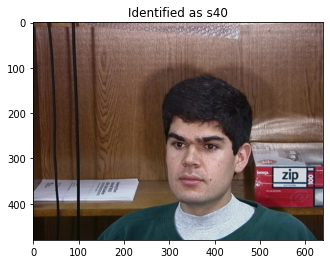

In [ ]:
example_idx = 40

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

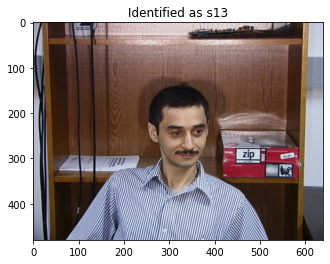

In [ ]:
example_idx = 50

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

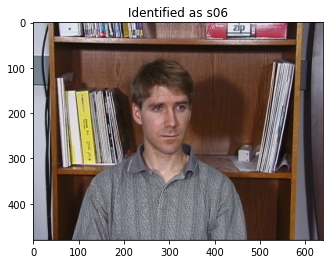

In [ ]:
example_idx = 80

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx] 
example_identity =  y_predict_encoded[example_idx] 

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

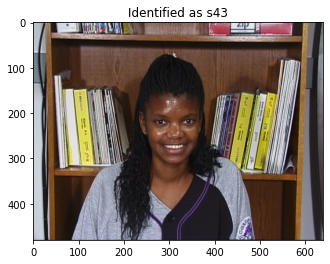

In [ ]:
example_idx = -27

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');